# Time Series Analysis
### Problem Statement
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

You can get the dataset here https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/


In [1]:
#importing all the required packages. These are quite the standard packages required.

import pandas as pd          #For dataframe related operations
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
%matplotlib inline
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [76]:
#Lets import the dataset
train=pd.read_csv("Train_SU63ISt.csv")
test=pd.read_csv("Test_0qrQsBZ.csv")

In [77]:
#Always a good practice to keep a duplicate copy of the data set 
train_original=train.copy()
test_original=test.copy()

In [78]:
#Lets check at the contents of the columns
train.columns, test.columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
ID          18288 non-null int64
Datetime    18288 non-null object
Count       18288 non-null int64
dtypes: int64(2), object(1)
memory usage: 428.7+ KB


In [84]:
#From the above step we realized that we have a datetime column but it is in type object, so lets 
# change it to datetime object so that we can perform timeseries operations on it. If you already know
# that your dataset is having a timeseries object then we can parse those columns as timeseries while 
# reading the csv itself. 

train["Datetime"]=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [85]:
print(train.head())
test.head() #As seen we need to predict the count of the passengers for the test dataset

   ID            Datetime  Count
0   0 2012-08-25 00:00:00      8
1   1 2012-08-25 01:00:00      2
2   2 2012-08-25 02:00:00      6
3   3 2012-08-25 03:00:00      2
4   4 2012-08-25 04:00:00      2


,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00


## Hypothesis test
The dataset contains timeseries data of the count of passengers on a particular service. Now to understand or forecast the count of passengers in future we can make below hypothesis.
1. We can expect an increase trend in the number of passengers as the population has an increasing trend and as JetRail is a new transportation media, more people would be interested in expereiencing it. ( check the relationship between independent variable Year vs. dependent variable passenger count)
2. We can expect higher traffic from the month of May to October as that is when most of the people travel during summer break.( check the relationship between independent variable month of May - Oct vs. dependent variable passenger count)
3. We can expect more traffic on weekdays compared to weekends for obvious reasons. ( check the relationship between independent variable Weekdays vs. dependent variable passenger count)
4. Expect more traffic during peak working hours. ( check the relationship between independent variable time of the day/ Hour vs. dependent variable passenger count)

As from above statements we can understand that there is a need to create new features from the given timeseries column. Lets do that by using the package datetime which provides an easy way to manipulate datetime objects.


In [86]:
# Lets breakdown the given timeseries object in year,month,day and hour to create more features thus
# simplifying the prediction process further
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [88]:
#Lets now get the day of the week
train['day of week']=train['Datetime'].dt.dayofweek
temp = train['Datetime']


In [98]:
#Lets get a column stating if the given date belongs to a weekend(1) or a weekday(0)

def weekend_check(row):
    if row ==5 or row ==6:
        return 1
    else:
        return 0


In [99]:
train['weekend']= train['day of week'].apply(weekend_check)

In [100]:
train.head()

,ID,Datetime,Count,year,month,day,Hour,day of week,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1


Alright, so now we have think we have all the features that we need for our modelling. We shall add more 
features as we progress further into the project.
The first column ID is simply constant incremental object and would not be helpful in determining the
dependent variable so lets drop that.

In [101]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis.
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.

Lets now make our first visualization to understand the trend of passenger count as the time passes.

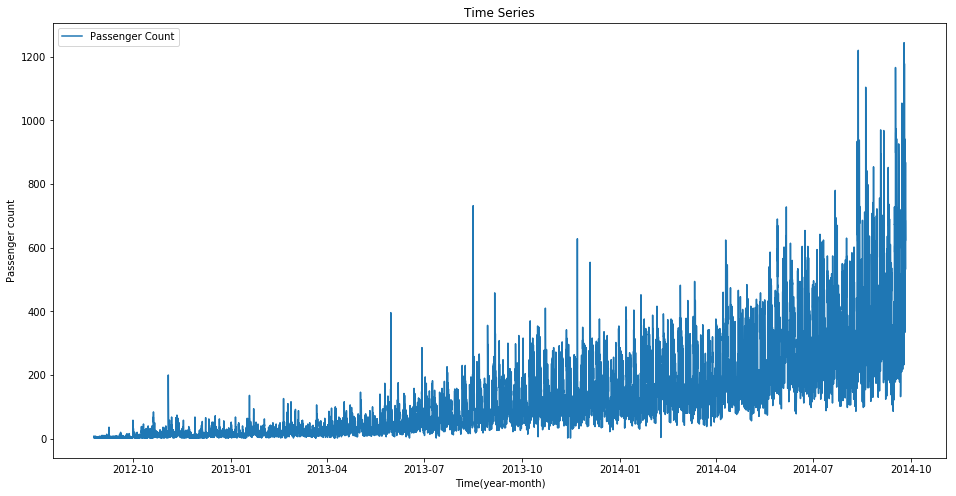

In [102]:
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

The above figure simply plots the trend of passengers count (min to max) for a particular time period.
We can understand from this plot that the datetime variable starts from 08-2012 till 10-2014. But this
plot is very noisy due to the level of granularity being too high. Lets try to drill up a bit to get a 
clear trend!

Below we peform some more exploratory data analysis to get better understanding of the data and trend

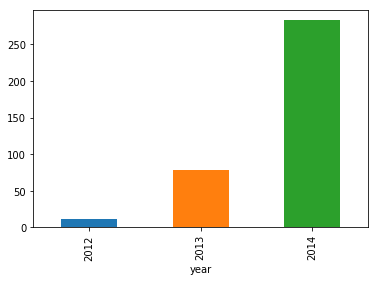

In [106]:
# Year wise count
train.groupby('year')['Count'].mean().plot.bar()

#From the below plot we can clearly see the increasing trend in passenger count with each yearb

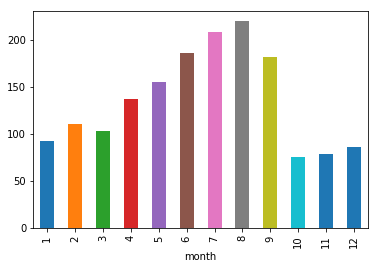

In [107]:
# Month wise count plot to check for seasonality if any

train.groupby('month')['Count'].mean().plot.bar()

#But the problem with below plot is that it is not considering year 

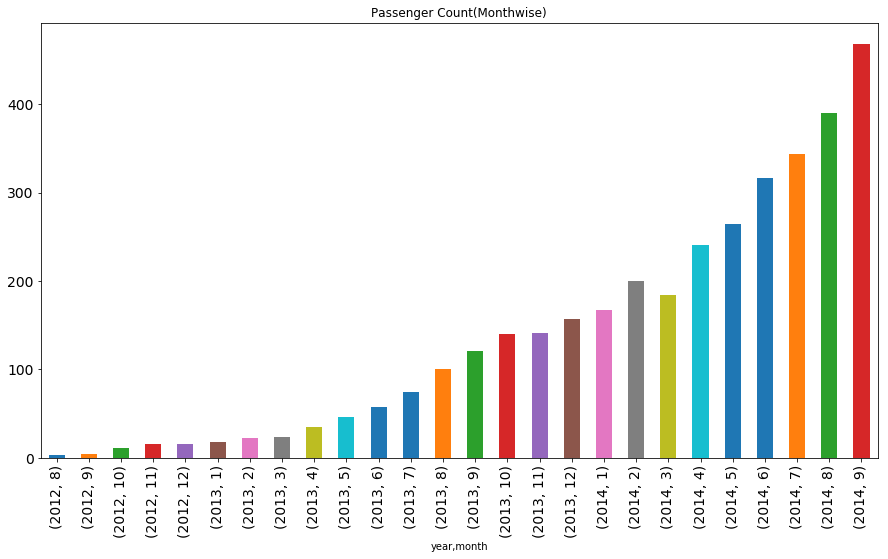

In [112]:
temp=train.groupby(['year', 'month'])['Count'].mean()
temp.plot.bar(figsize=(15,8), title= 'Passenger Count(Monthwise)', fontsize=14)

we definitely see a monthly increasing trend of customers. Lets see how the daily and hourly trend 
looks like

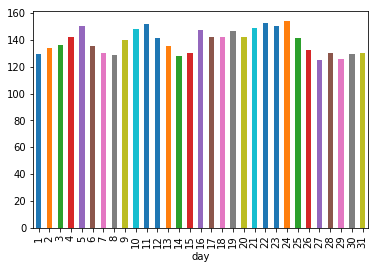

In [113]:
# daywise count
train.groupby('day')['Count'].mean().plot.bar()

# We definitely see a seasonal pattern here of traffic increasing through weekdays and going down on weekends

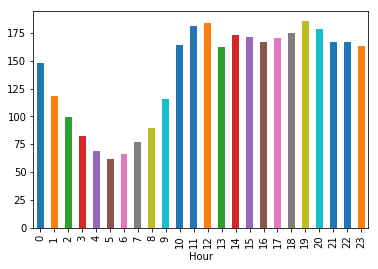

In [114]:
# hourly passenger count
train.groupby('Hour')['Count'].mean().plot.bar()

#As we can anticipate the passenger count goes down during midnight from 1-5am and then count starts going
# up again

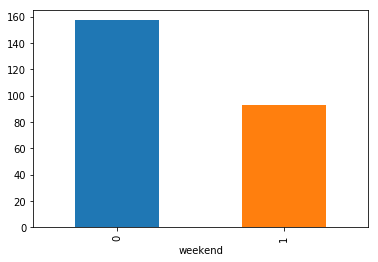

In [115]:
# Count on weekend
train.groupby('weekend')['Count'].mean().plot.bar()

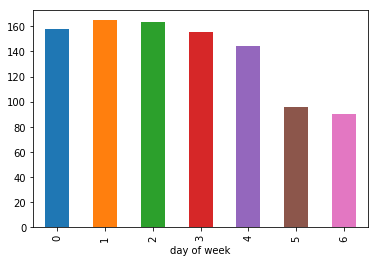

In [116]:
train.groupby('day of week')['Count'].mean().plot.bar()

From the exploration performed so far on the data we can understand that there is clearly a lot of noise in the data as it is in hourly manner and we need a more summarized data for modeling purpose making it easier and faster for the model to learn.

In [117]:
#Lets start by dropping the unnecessary ID column and summarize the dataset using model resampling 
# techniques provided by pandas.

# drop ID from train
train=train.drop('ID',1)

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()

# Converting to daily mean
daily = train.resample('D').mean()

# Converting to weekly mean
weekly = train.resample('W').mean()

# Converting to monthly mean
monthly = train.resample('M').mean()

Resampling: It’s a technique similar to groupby used for creating bins/bucket of timeframes without actually grouping them.
It can be downsampled- aggregating for a time larger than the each record time, upsampled- aggregating for a time smaller than each record time. <br>
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
http://benalexkeen.com/resampling-time-series-data-with-pandas/


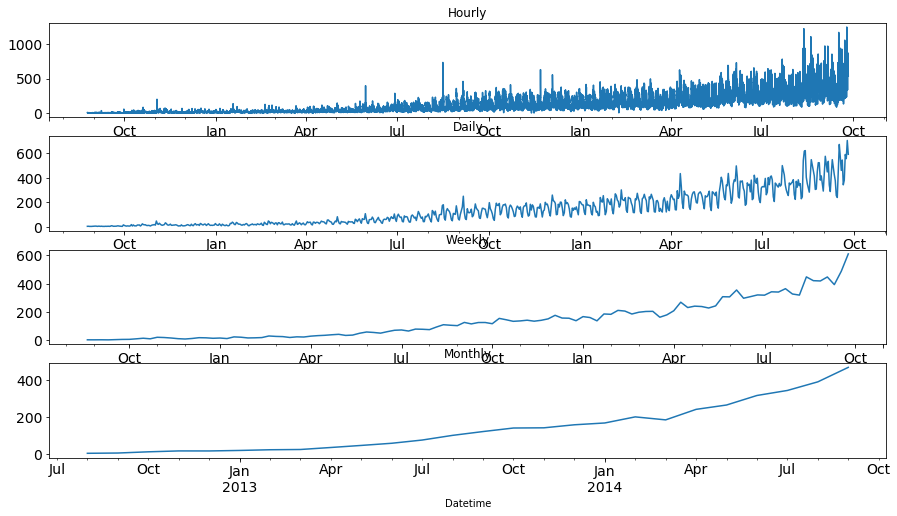

In [120]:
#Now lets plot these summarized resampled datasets

fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [121]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

## Model Building:

In [129]:
train.index.min(),train.index.max()

(Timestamp('2012-08-25 00:00:00', freq='D'),
 Timestamp('2014-09-25 00:00:00', freq='D'))

As seen above we have 25 months data, it would be a good idea to keep most of the data as part of training and rest as validation set. Lets keep the last 3 months for the validation set. Remember we are simply splitting the training dataset further in train and validation set to build our model. Later this model would be applied on the test data set given separately.

In [122]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-25':'2014-09-25']


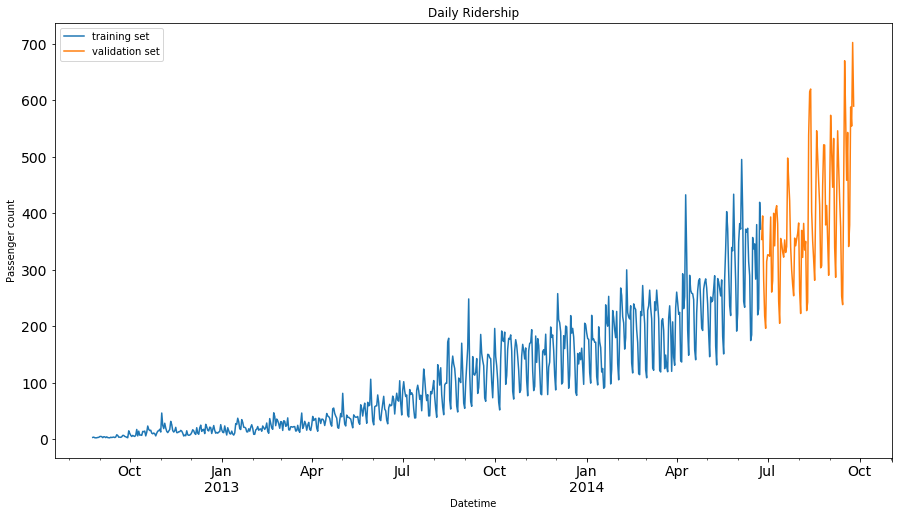

In [130]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='training set')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='validation set')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()